<a href="https://colab.research.google.com/github/yeoun9/torchpm/blob/main/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install git+https://github.com/yeoun9/torchpm.git
! pip install torchpm

In [2]:
from torchpm import *
from torchpm.data import CSVDataset
from torchpm.parameter import *
import torch as tc
import numpy as np
import matplotlib.pyplot as plt

# Model Building

In [49]:
dataset_file_path = 'https://raw.githubusercontent.com/yeoun9/torchpm/main/examples/THEO.csv'
dataset_np = np.loadtxt(dataset_file_path, delimiter=',', dtype=np.float32, skiprows=1)
device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
column_names = ['ID', 'AMT', 'TIME', 'DV', 'CMT', "MDV", "RATE", 'BWT']
dataset = CSVDataset(dataset_np, column_names, device)

class BasementModel(predfunction.PredictionFunctionByTime) :
    
    def _set_estimated_parameters(self):
        self.theta_0 = Theta(0., 1.5, 10.)
        self.theta_1 = Theta(0., 30., 100.)
        self.theta_2 = Theta(0, 0.08, 1)

        self.eta_0 = Eta()
        self.eta_1 = Eta()
        self.eta_2 = Eta()

        self.eps_0 = Eps()
        self.eps_1 = Eps()
    
    def _calculate_parameters(self, covariates):
        covariates['k_a'] = self.theta_0()*tc.exp(self.eta_0())
        covariates['v'] = self.theta_1()*tc.exp(self.eta_1())#*para['BWT']/70
        covariates['k_e'] = self.theta_2()*tc.exp(self.eta_2())
        covariates['AMT'] = tc.tensor(320., device=self.dataset.device)

    def _calculate_preds(self, t, p):
        dose = p['AMT'][0]
        k_a = p['k_a']
        v = p['v']
        k_e = p['k_e']
        return (320 / v * k_a) / (k_a - k_e) * (tc.exp(-k_e*t) - tc.exp(-k_a*t))
        
    def _calculate_error(self, y_pred, p):
        p['v_v'] = p['v'] 
        return y_pred +  y_pred * self.eps_0() + self.eps_1()

model = models.FOCEInter(dataset=dataset,
                        pred_function_module=BasementModel,
                        theta_names=['theta_0', 'theta_1', 'theta_2'],
                        eta_names= ['eta_0', 'eta_1','eta_2'], 
                        eps_names= ['eps_0','eps_1'], 
                        omega=Omega([0.4397,
                                    0.0575,  0.0198, 
                                    -0.0069,  0.0116,  0.0205], False, requires_grads=False), 
                        sigma=Sigma([[0.0177], 
                                    [0.0762]], [True, True], requires_grads=[False, True]),
                        output_column_names=['ID', 'TIME', 'AMT', 'k_a', 'v', 'k_e'],)
                        
model = model.to(device)
model = model.fit_population(learning_rate = 1, tolerance_grad = 1e-3, tolerance_change= 1e-3)

running_time :  0.719001293182373 	 total_loss: tensor(490.1509, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  1.292001485824585 	 total_loss: tensor(403.7401, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  1.862684726715088 	 total_loss: tensor(343.5059, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  2.4306817054748535 	 total_loss: tensor(267.9600, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  3.0046780109405518 	 total_loss: tensor(243.7507, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  3.5849721431732178 	 total_loss: tensor(202.4627, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  4.157972097396851 	 total_loss: tensor(168.2006, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  4.738972187042236 	 total_loss: tensor(137.0659, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  5.310972213745117 	 total_loss: tensor(131.7247, device='cuda:0', grad_fn=<AddBackward0>)
running_time :  5.879972219467163 	 total_l

# Result

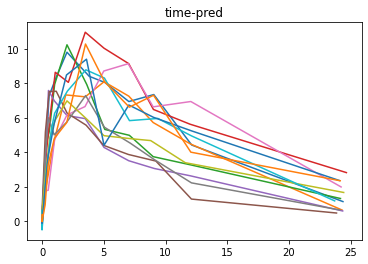

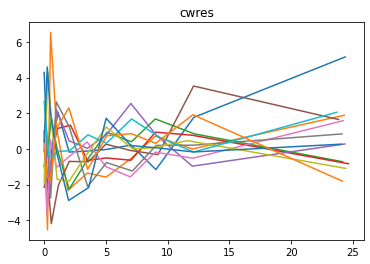

In [27]:
eval_result = model.descale().evaluate()

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_title('time-pred')
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
ax2.set_title('cwres')
for id, v in eval_result.items() :
    time = v['time'].to('cpu')
    y_pred = v['pred'].detach().to('cpu').numpy()
    cwres_value = v['cwres']
    ax1.plot(time, y_pred)
    time_masked = tc.masked_select(time.to('cpu'), v['mdv_mask'].to('cpu'))
    ax2.plot(time_masked.to('cpu').detach().numpy(), cwres_value.to('cpu').detach().numpy())
plt.show()

In [8]:
for id, values in eval_result.items():
    print('====================================',
        '\n id:', id)
    for key, value in values.items():
        print(key, " : ", value)

 id: 1
loss  :  tensor(20.0911, device='cuda:0', grad_fn=<SqueezeBackward0>)
cwres  :  tensor([ 2.6825, -1.0007,  0.4846,  1.6283,  0.0753, -0.2723,  0.1214,  0.2569,
         0.6541,  1.0656,  2.3478], device='cuda:0', grad_fn=<MvBackward0>)
pred  :  tensor([ 0.0000,  0.0000,  3.3558,  6.2205,  8.8344, 10.1257,  9.6696,  8.9482,
         7.8974,  6.9202,  5.6607,  2.5392], device='cuda:0',
       grad_fn=<AddBackward0>)
time  :  tensor([ 0.0000,  0.0000,  0.2500,  0.5700,  1.1200,  2.0200,  3.8200,  5.1000,
         7.0300,  9.0500, 12.1200, 24.3700], device='cuda:0')
mdv_mask  :  tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True], device='cuda:0')
ID  :  [tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')]
TIME  :  [tensor([ 0.0000,  0.0000,  0.2500,  0.5700,  1.1200,  2.0200,  3.8200,  5.1000,
         7.0300,  9.0500, 12.1200, 24.3700], device='cuda:0')]
AMT  :  [tensor([320., 320., 320., 320., 320., 320., 320.

In [11]:
cov_result = model.descale().covariance_step()
for k, v in cov_result.items() :
    print(k, " : ", v)

id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
cov  :  tensor([[ 3.3669e-03,  2.6808e-02, -1.5345e-04,  1.7823e-03,  2.5741e-04,
          1.1856e-04,  1.3611e-04,  1.8653e-04,  3.2246e-04, -3.5966e-04,
          2.9292e-03],
        [ 2.6828e-02,  3.4768e-01, -1.4935e-03,  1.0459e-02, -1.1512e-03,
          5.2675e-04, -1.6774e-03,  1.3393e-03,  2.2701e-03, -1.1355e-03,
          9.0516e-03],
        [-1.5353e-04, -1.4929e-03,  7.7119e-06, -5.4955e-05, -3.1857e-06,
         -4.6369e-06, -9.0015e-07, -8.6462e-06, -1.4391e-05,  1.3847e-05,
         -1.0640e-04],
        [ 1.7840e-03,  1.0369e-02, -5.4945e-05,  3.1977e-02,  4.3212e-03,
          3.5835e-04,  7.4651e-04, -1.1856e-04, -3.9560e-04, -1.9940e-04,
         -2.6753e-03],
        [ 2.5795e-04, -1.1656e-03, -3.1955e-06,  4.3131e-03,  7.6672e-04,
          7.8134e-05,  3.1797e-04,  6.4621e-07, -5.1994e-05, -5.0230e-05,
         -1.8345e-04],
        [ 1.1847e-04,  5.2356e-04, -4.6324e-06,  3.5525e-04,  7.7687e-05,


In [21]:
for para_category in ['.theta', 'omega', 'sigma', '.eta']:
    for (name, para) in model.named_parameters():
        if name.find(para_category) > -1 :
            print(name)
            print(para.detach().clone().to('cpu').numpy())

pred_function_module.theta_0.parameter_value
1.4048289
pred_function_module.theta_1.parameter_value
32.17639
pred_function_module.theta_2.parameter_value
0.086920306
omega.parameter_values.0
[0.43968296 0.05751008 0.01980773 0.0069004  0.01340452 0.02049107]
sigma.parameter_values.0
[0.01770407]
sigma.parameter_values.1
[0.07610917]
pred_function_module.eta_0.parameter_values.1
-0.048240732
pred_function_module.eta_0.parameter_values.2
0.3971118
pred_function_module.eta_0.parameter_values.3
0.47173664
pred_function_module.eta_0.parameter_values.4
-0.275946
pred_function_module.eta_0.parameter_values.5
0.030523952
pred_function_module.eta_0.parameter_values.6
-0.39844483
pred_function_module.eta_0.parameter_values.7
-0.7831197
pred_function_module.eta_0.parameter_values.8
0.005493285
pred_function_module.eta_0.parameter_values.9
1.447223
pred_function_module.eta_0.parameter_values.10
-0.6438662
pred_function_module.eta_0.parameter_values.11
0.934943
pred_function_module.eta_0.parameter_

# Simulation

In [ ]:
tc.manual_seed(42)
simulation_result = model.simulate(dataset, 300)

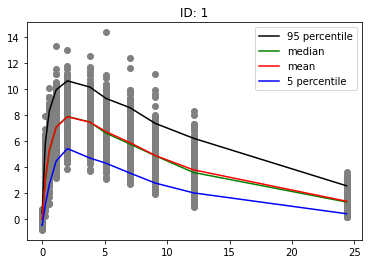

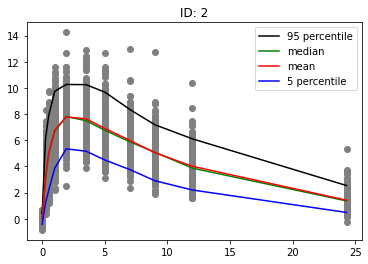

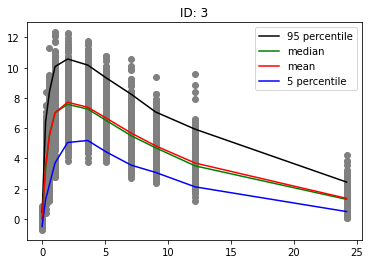

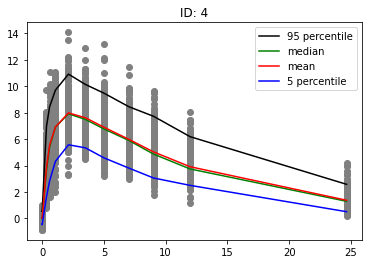

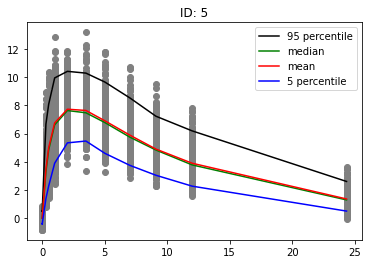

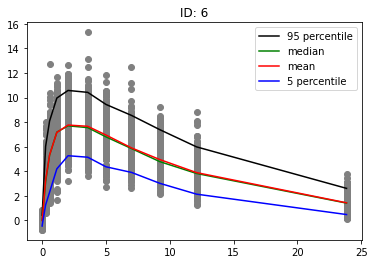

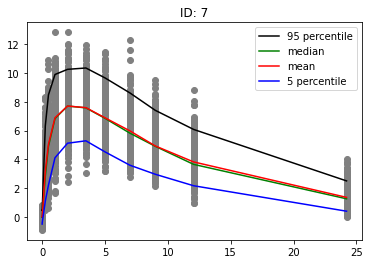

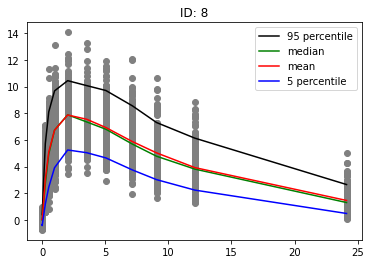

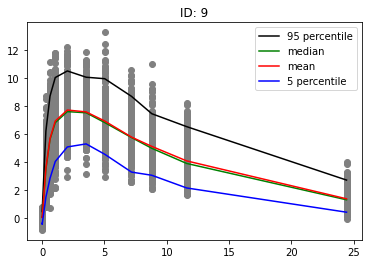

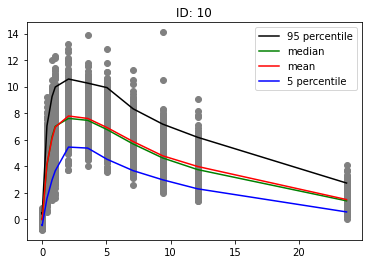

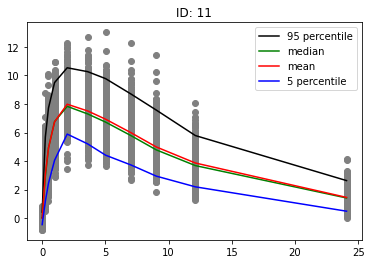

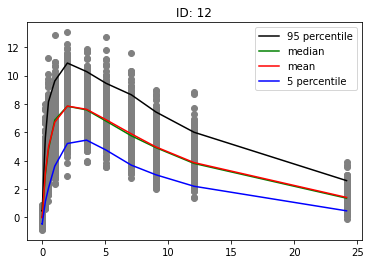

In [48]:
for id, values in simulation_result.items() :
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('ID: '+ id)
    time_data : tc.Tensor = values['time'].to('cpu')
    
    preds : List[tc.Tensor] = values['preds']
    preds_tensor = tc.stack(preds).to('cpu')
    p95 = np.percentile(preds_tensor, 95, 0)
    p50 = np.percentile(preds_tensor, 50, 0)
    average = np.average(preds_tensor, 0)
    p5 = np.percentile(preds_tensor, 5, 0)
    
    ax.plot(time_data, p95, color="black", label='95 percentile')
    ax.plot(time_data, p50, color="green", label='median')
    ax.plot(time_data, average, color="red", label='mean')
    ax.plot(time_data, p5, color="Blue", label ='5 percentile')

    for y_pred in values['preds'] :
        ax.scatter(time_data, y_pred.detach().to('cpu'), color='gray')
    plt.legend(loc='upper right')
    plt.show()